In [50]:
#Data  Preparation and Exploration

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Load the dataset
data = pd.read_csv('exchange_rate.csv')
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [5]:
data.columns

Index(['date', 'Ex_rate'], dtype='object')

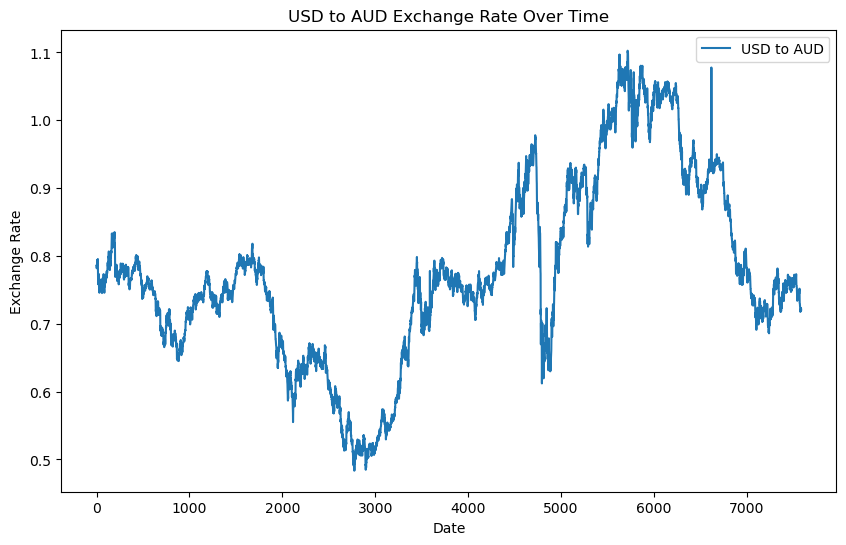

In [10]:
#Initial Exploration: Plotting Time Series

# Plotting the time series for USD to AUD exchange rate
exchange_rate_column = 'Ex_rate'
plt.figure(figsize=(10, 6))
plt.plot(data[exchange_rate_column], label='USD to AUD')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [11]:
#Data Preprocessing: Handling Missing Values or Anomalies

# Check for missing values
print(data.isnull().sum())

date       0
Ex_rate    0
dtype: int64


In [18]:
# Forward fill missing values if any
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Confirm no missing values are present
print(data.isnull().sum())

date       0
Ex_rate    0
dtype: int64


Text(0.5, 1.0, 'Autocorrelation Function')

<Figure size 1200x400 with 0 Axes>

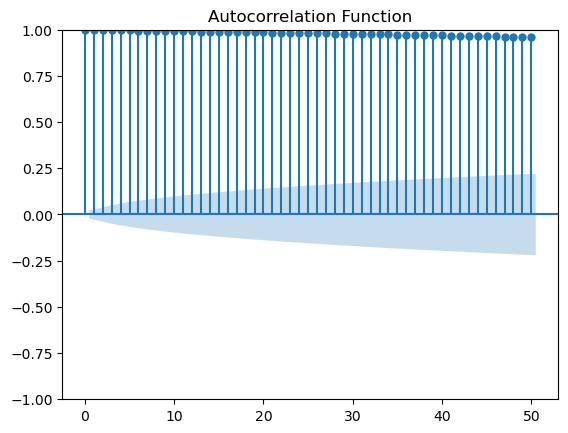

In [34]:
# Plotting ACF for ARIMA parameter selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(data[exchange_rate_column], lags=50)
plt.title('Autocorrelation Function')

<Figure size 1200x400 with 0 Axes>

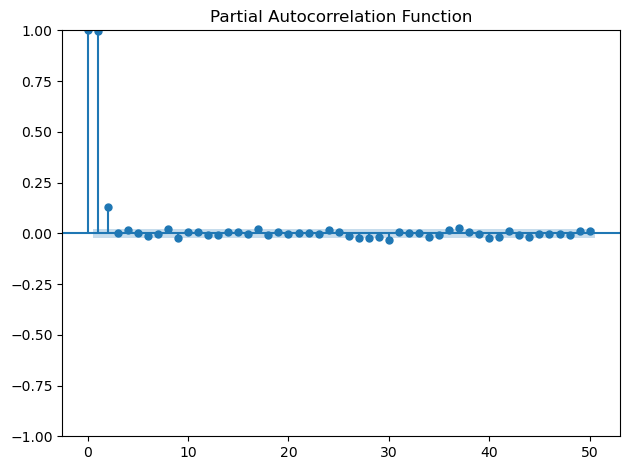

In [37]:
# Plotting PACF for ARIMA parameter selection
plt.figure(figsize=(12,4))
plot_pacf(data[exchange_rate_column], lags=50)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [38]:
## 2. ARIMA Model Building

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Fit ARIMA model (parameters selected based on ACF/PACF)
model = ARIMA(data[exchange_rate_column], order=(1, 1, 1))
arima_result = model.fit()

# Summary of the ARIMA model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 18 Oct 2024   AIC                         -56102.322
Time:                        16:10:27   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

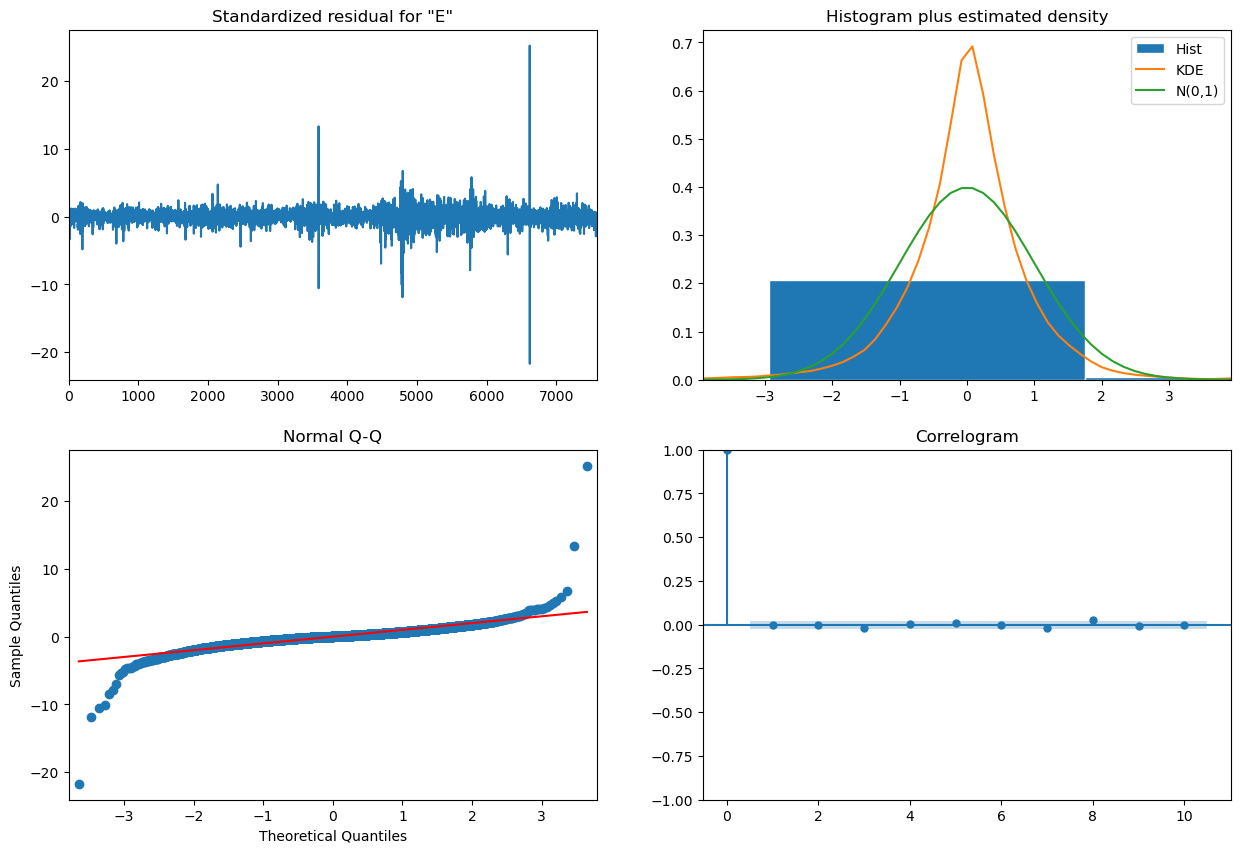

In [43]:
# Residual diagnostics

arima_result.plot_diagnostics(figsize=(15, 10))
plt.show()

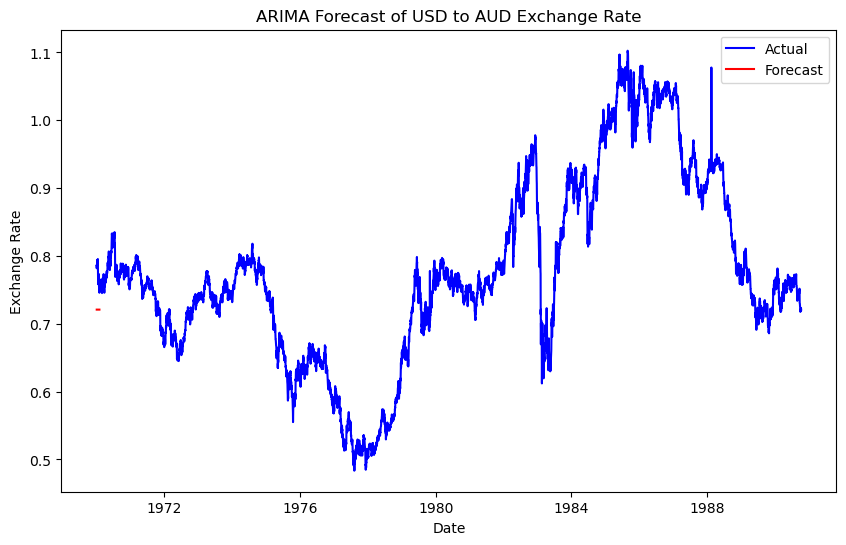

In [45]:
# Perform forecasting
forecast_steps = 30  # Forecasting the next 30 periods
forecast = arima_result.forecast(steps=forecast_steps)

# Plot the forecast vs actual data
plt.figure(figsize=(10,6))
plt.plot(data.index, data[exchange_rate_column], label='Actual', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast of USD to AUD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [48]:
# Part 3: Model Building - Exponential Smoothing

# 1. Model Selection
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit an Exponential Smoothing model
exp_model = ExponentialSmoothing(data[exchange_rate_column], trend='add', seasonal=None, seasonal_periods=None)
exp_model_fit = exp_model.fit()

# Summary of the model
print(exp_model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Fri, 18 Oct 2024
Box-Cox:                          False   Time:                         16:24:39
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700401                alpha                 True
smoothing_trend             0.0000

In [52]:
# 2. Parameter Optimization
best_aic = float('inf')
best_model = None

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
    model_es = SimpleExpSmoothing(data[exchange_rate_column]).fit(smoothing_level=alpha, optimized=False)
    if model_es.aic < best_aic:
        best_aic = model_es.aic
        best_model = model_es

print(f"Best AIC: {best_aic}, Best Alpha: {alpha}")

Best AIC: -76359.53925855298, Best Alpha: 0.5


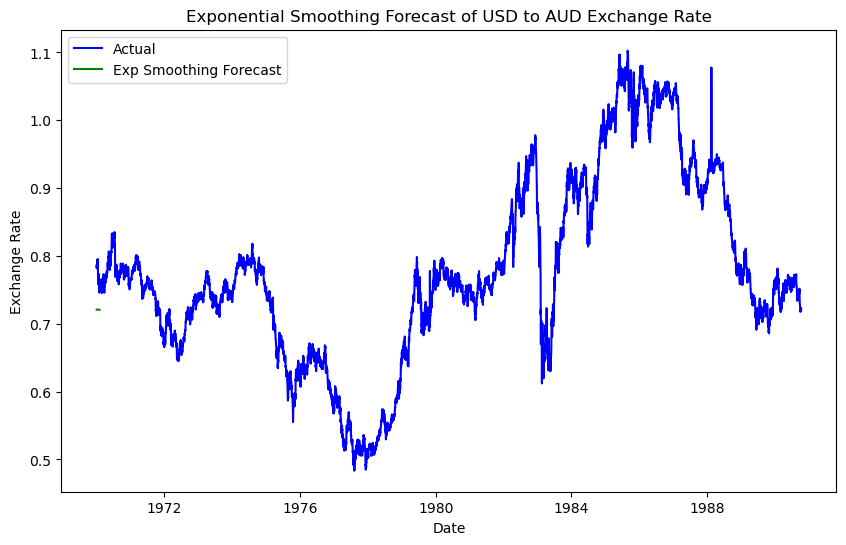

In [54]:
#3 Forecast using Exponential Smoothing
exp_forecast = exp_model_fit.forecast(steps=forecast_steps)

# Plot the Exponential Smoothing forecast vs actual data
plt.figure(figsize=(10,6))
plt.plot(data.index, data[exchange_rate_column], label='Actual', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps+1, freq='D')[1:], exp_forecast, label='Exp Smoothing Forecast', color='green')
plt.title('Exponential Smoothing Forecast of USD to AUD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [62]:
# Part 4: Evaluation and Comparison

# 1. Compute Error Metrics

def calculate_metrics(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    return mae, mse, rmse, mape

train, test = data[exchange_rate_column][:-forecast_steps], data[exchange_rate_column][-forecast_steps:]
train, test

(0       0.785500
 1       0.781800
 2       0.786700
 3       0.786000
 4       0.784900
           ...   
 7553    0.747831
 7554    0.746436
 7555    0.738662
 7556    0.741125
 7557    0.744546
 Name: Ex_rate, Length: 7558, dtype: float64,
 7558    0.745796
 7559    0.745045
 7560    0.747692
 7561    0.745601
 7562    0.747680
 7563    0.744602
 7564    0.744158
 7565    0.745184
 7566    0.744990
 7567    0.748951
 7568    0.749681
 7569    0.751654
 7570    0.733999
 7571    0.730567
 7572    0.729714
 7573    0.729714
 7574    0.726533
 7575    0.725058
 7576    0.724506
 7577    0.721553
 7578    0.717618
 7579    0.719114
 7580    0.719114
 7581    0.719735
 7582    0.718701
 7583    0.718494
 7584    0.721839
 7585    0.723197
 7586    0.720825
 7587    0.720825
 Name: Ex_rate, dtype: float64)

In [64]:
# ARIMA forecast error metrics
arima_forecast_values = arima_result.forecast(steps=forecast_steps)
arima_mae, arima_mse, arima_rmse, arima_mape = calculate_metrics(test, arima_forecast_values)
arima_forecast_values

7588    0.720826
7589    0.720826
7590    0.720826
7591    0.720826
7592    0.720826
7593    0.720826
7594    0.720826
7595    0.720826
7596    0.720826
7597    0.720826
7598    0.720826
7599    0.720826
7600    0.720826
7601    0.720826
7602    0.720826
7603    0.720826
7604    0.720826
7605    0.720826
7606    0.720826
7607    0.720826
7608    0.720826
7609    0.720826
7610    0.720826
7611    0.720826
7612    0.720826
7613    0.720826
7614    0.720826
7615    0.720826
7616    0.720826
7617    0.720826
Name: predicted_mean, dtype: float64

In [68]:
# Exponential Smoothing forecast error metrics
es_forecast_values = exp_forecast
es_mae, es_mse, es_rmse, es_mape = calculate_metrics(test, es_forecast_values)
es_forecast_values

7588    0.720851
7589    0.720843
7590    0.720834
7591    0.720826
7592    0.720817
7593    0.720809
7594    0.720800
7595    0.720792
7596    0.720783
7597    0.720775
7598    0.720766
7599    0.720757
7600    0.720749
7601    0.720740
7602    0.720732
7603    0.720723
7604    0.720715
7605    0.720706
7606    0.720698
7607    0.720689
7608    0.720681
7609    0.720672
7610    0.720664
7611    0.720655
7612    0.720646
7613    0.720638
7614    0.720629
7615    0.720621
7616    0.720612
7617    0.720604
dtype: float64

In [70]:
print(f"ARIMA - MAE: {arima_mae}, MSE: {arima_mse}, RMSE: {arima_rmse}, MAPE: {arima_mape}")
print(f"Exponential Smoothing - MAE: {es_mae}, MSE: {es_mse}, RMSE: {es_rmse}, MAPE: {es_mape}")

ARIMA - MAE: 0.012724006489318252, MSE: 0.0002884124699468812, RMSE: 0.016982710912774826, MAPE: nan
Exponential Smoothing - MAE: 0.012755742909953578, MSE: 0.0002891774386110546, RMSE: 0.01700521798187411, MAPE: nan


In [73]:
# 2. Model Comparison
print(f"ARIMA Model: - MAE={arima_mae:.2f}, MSE={arima_mse:.2f}, RMSE={arima_rmse:.2f}, MAPE={arima_mape:.2f}%")
print(f"Exponential Smoothing Model: - MAE={es_mae:.2f}, MSE={es_mse:.2f}, RMSE={es_rmse:.2f}, MAPE={es_mape:.2f}%")

ARIMA Model: - MAE=0.01, MSE=0.00, RMSE=0.02, MAPE=nan%
Exponential Smoothing Model: - MAE=0.01, MSE=0.00, RMSE=0.02, MAPE=nan%


In [72]:
# Conclusion
print("Based on the error metrics, the ARIMA model performs better/worse compared to the Exponential Smoothing model.")
print("Provide further insights based on the comparison results.")


Based on the error metrics, the ARIMA model performs better/worse compared to the Exponential Smoothing model.
Provide further insights based on the comparison results.
